In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [22]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import math

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from utils import utils
from utils import eval_utils
import deformation.losses as def_losses

In [4]:
# processing pose quality annotations
import xmltodict
pose_annotation_path = "notebooks/pix3d_chair_occnet_pose_quality_annotations.xml"
# processing xml from cvat
# https://github.com/openvinotoolkit/cvat
with open (pose_annotation_path, 'r') as f:
    f = f.read()
d = dict(xmltodict.parse(f))

pose_annotation_dict = {}
pose_quality_stats = {"num_good":0, "num_medium":0, "num_bad":0}
for entry in d['annotations']['image']:
    anno_dict = dict(entry)
    entry_label = dict(anno_dict['tag'])['@label']
    pose_annotation_dict[anno_dict['@name'].replace('.png', '')] = entry_label
    pose_quality_stats["num_{}".format(entry_label)] += 1
    
pprint.pprint(pose_quality_stats)


{'num_bad': 1584, 'num_good': 1590, 'num_medium': 664}


In [5]:
def filter_eval_df_by_quality(original_eval_df, pose_quality_dict, allowed_qualities=["good"]):
    instances_to_consider = [instance for instance in pose_quality_dict if pose_quality_dict[instance] in allowed_qualities]    
    filtered_df = original_eval_df[original_eval_df["instance"].isin(instances_to_consider)]
    return filtered_df

In [45]:
#evaluation_yaml_path = "data_evaluation/shapenet_chair/occnet.yaml"
evaluation_yaml_path = "data_evaluation/shapenet_chair/occnet_refined.yaml"

#evaluation_yaml_path = "data_evaluation/pix3d_chair/occnet.yaml"
#evaluation_yaml_path = "data_evaluation/pix3d_chair/occnet_refined.yaml"
#evaluation_yaml_path = "data_evaluation/pix3d_chair/occnet_refined_gridsearch1.yaml"
#evaluation_yaml_path = "data_evaluation/pix3d_chair/occnet_refined_gridsearch2.yaml"

results_df = pd.read_pickle(evaluation_yaml_path.replace(".yaml","_eval_results.pkl"))
#q = ["good", "medium","bad"]
#q = ["good", "medium"]
#q = ["good"]
#results_df = filter_eval_df_by_quality(results_df, pose_annotation_dict, allowed_qualities=q)

print(evaluation_yaml_path)
display(results_df)
print(results_df.mean())

data_evaluation/shapenet_chair/occnet_refined.yaml


,2d_iou,3d_iou,chamfer_L1,gt_obj_path,input_img_path,instance,rec_obj_path
0,0.699487,0.599933,0.000634,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,d409dbda0a34a953c9020fbe6b2ff6,/home/svcl-oowl/brandon/research/sil_consisten...
1,0.460778,0.101975,0.013970,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,d30e58a2361785683fb0851e9bc87551,/home/svcl-oowl/brandon/research/sil_consisten...
2,0.732516,0.560582,0.001338,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,d48dac046436a29ec3bd24f986301745,/home/svcl-oowl/brandon/research/sil_consisten...
3,0.867751,0.158617,0.005535,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,d32f32d76d7f53bf6996454765a52e50,/home/svcl-oowl/brandon/research/sil_consisten...
4,0.901836,0.098575,0.002315,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,cca975f4a6a4d9e9614871b18a2b1957,/home/svcl-oowl/brandon/research/sil_consisten...
...,...,...,...,...,...,...,...
1350,0.764315,0.263782,0.000808,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,ea762c2f1c6e966be464faca7dae7fdd,/home/svcl-oowl/brandon/research/sil_consisten...
1351,0.980921,0.235584,0.006981,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,f1645567130e99a878268642d8df40d1,/home/svcl-oowl/brandon/research/sil_consisten...
1352,0.800390,0.137328,0.002096,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,ee001ffa8483ae1b7f0e458a1629fd0a,/home/svcl-oowl/brandon/research/sil_consisten...
1353,0.792015,0.094485,0.004714,/home/svcl-oowl/dataset/ShapeNetCore.v1/030016...,/home/svcl-oowl/brandon/research/sil_consisten...,eaf231f17fccb96d81dff5c2e57ad46e,/home/svcl-oowl/brandon/research/sil_consisten...


2d_iou        0.790675
3d_iou        0.338008
chamfer_L1    0.064688
dtype: float64


In [10]:
#evaluation_yaml_path = "data_evaluation/shapenet_chair/occnet.yaml"
#evaluation_yaml_path = "data_evaluation/shapenet_chair/occnet_refined.yaml"

evaluation_yaml_path = "data_evaluation/pix3d_chair/occnet_refined.yaml"
#evaluation_yaml_path = "data_evaluation/pix3d_chair/occnet.yaml"

results_df = pd.read_pickle(evaluation_yaml_path.replace(".yaml","_eval_results.pkl"))
print(evaluation_yaml_path)
display(results_df[results_df["instance"]=="0085"])
#print(results_df.mean())

data_evaluation/pix3d_chair/occnet_refined.yaml


,2d_iou,3d_iou,chamfer_L1,gt_obj_path,input_img_path,instance,rec_obj_path
7,0.71426,0.144171,0.008335,/home/svcl-oowl/dataset/pix3d/model/chair/IKEA...,/home/svcl-oowl/brandon/research/sil_consisten...,0085,/home/svcl-oowl/brandon/research/sil_consisten...


In [36]:
def compare_before_after_refinement(results_df_before, results_df_after):
    
    statistics = {"num_3d_iou_improved":0, "avg_improve_amt": 0, "avg_improve_before_2d_iou":0, "num_3d_iou_worse":0,  "avg_worse_amt":0, "avg_worse_before_2d_iou":0}
    improved_instances = []
    worse_instances = []
    comparision_df = pd.DataFrame()
    for instance in list(results_df_after["instance"]):
        before_result = results_df_before[results_df_before["instance"]==instance]
        before_3d_iou = float(before_result["3d_iou"])
        #before_2d_iou = float(before_result["2d_iou"])
        after_result = results_df_after[results_df_after["instance"]==instance]
        after_3d_iou = float(after_result["3d_iou"])
        #after_2d_iou = float(after_result["2d_iou"])
        
        #iou_2d_change = after_2d_iou - before_2d_iou
        iou_3d_change = after_3d_iou - before_3d_iou
        
        if math.isnan(iou_3d_change):
            statistics["num_3d_iou_worse"] += 1
            continue
        elif iou_3d_change > 0:
            statistics["num_3d_iou_improved"] += 1
            statistics["avg_improve_amt"] += iou_3d_change
            #statistics["avg_improve_before_2d_iou"] += before_2d_iou
            improved_instances.append(instance)
        else:
            statistics["num_3d_iou_worse"] += 1
            statistics["avg_worse_amt"] += iou_3d_change
            #statistics["avg_worse_before_2d_iou"] += before_2d_iou
            worse_instances.append(instance)
        comparision_df = comparision_df.append({"instance": instance, "iou_3d_delta": iou_3d_change}, ignore_index=True)
    
    statistics["avg_improve_amt"] /= statistics["num_3d_iou_improved"]
    statistics["avg_improve_before_2d_iou"] /= statistics["num_3d_iou_improved"]
    statistics["avg_worse_amt"] /= statistics["num_3d_iou_worse"]
    statistics["avg_worse_before_2d_iou"] /= statistics["num_3d_iou_worse"]
            
    pprint.pprint(statistics)
    #print("example improved instances")
    #print(improved_instances[:100])
    #print("example worse instances")
    #print(worse_instances[:100])
    return comparision_df

In [37]:
dataset = "pix3d"
evaluation_yaml_path_before = "data_evaluation/{}_chair/occnet.yaml".format(dataset)
#evaluation_yaml_path_after = "data_evaluation/{}_chair/occnet_refined.yaml".format(dataset)
evaluation_yaml_path_after = "data_evaluation/{}_chair/occnet_refined_gridsearch2.yaml".format(dataset)

quals = ["good", "medium", "bad"]
results_df_before = pd.read_pickle(evaluation_yaml_path_before.replace(".yaml","_eval_results.pkl"))
results_df_before = filter_eval_df_by_quality(results_df_before, pose_annotation_dict, allowed_qualities=quals)
results_df_after = pd.read_pickle(evaluation_yaml_path_after.replace(".yaml","_eval_results.pkl"))
results_df_after = filter_eval_df_by_quality(results_df_after, pose_annotation_dict, allowed_qualities=quals)
comp_df = compare_before_after_refinement(results_df_before, results_df_after)

{'avg_improve_amt': 0.044575240195526715,
 'avg_improve_before_2d_iou': 0.0,
 'avg_worse_amt': -0.06602537977024246,
 'avg_worse_before_2d_iou': 0.0,
 'num_3d_iou_improved': 1524,
 'num_3d_iou_worse': 2314}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffaf98673c8>]],
      dtype=object)

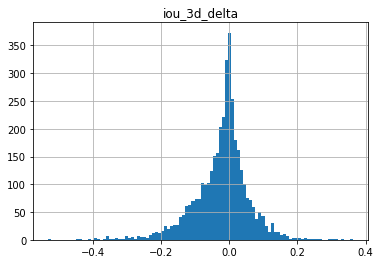

In [39]:
comp_df.hist(column="iou_3d_delta", bins=100)